In [1]:
import torch
import torch.nn as nn
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def activation(name):
    if name in ['tanh', 'Tanh']:
        return nn.Tanh()
    elif name in ['relu', 'ReLU']:
        return nn.ReLU(inplace=True)
    elif name in ['lrelu', 'LReLU']:
        return nn.LeakyReLU(inplace=True)
    elif name in ['sigmoid', 'Sigmoid']:
        return nn.Sigmoid()
    elif name in ['softplus', 'Softplus']:
        return nn.Softplus(beta=4)
    elif name in ['celu', 'CeLU']:
        return nn.CELU()
    elif name in ['elu']:
        return nn.ELU()
    elif name in ['mish']:
        return nn.Mish()
    else:
        raise ValueError('Unknown activation function')

In [3]:
class SlidingWindowDataset(Dataset):
    def __init__(self, time_data, temp_data, window_size, step_size):
        assert(time_data.shape[0] == temp_data.shape[0])

        self.time_data = time_data
        self.temp_data = temp_data
        self.window_size = window_size
        self.step_size = step_size

    def __len__(self):
        return ((self.time_data.shape[0] - 2*self.window_size) // self.step_size + 1)

    def __getitem__(self, idx):
        start_idx = idx * self.step_size
        mid_idx = start_idx + self.window_size
        end_idx = start_idx + 2*self.window_size
        
        data_in = torch.cat((self.time_data[start_idx:mid_idx], self.temp_data[start_idx:mid_idx]), dim=1)
        data_out = torch.cat((self.time_data[mid_idx:end_idx], self.temp_data[mid_idx:end_idx]), dim=1)
        return data_in, data_out

In [4]:
# Spectral (or Fourier) layer in 1d

class SpectralConv(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        # x.shape == [batch_size, in_channels, number of grid points]
        # hint: use torch.fft library torch.fft.rfft
        # use DFT to approximate the fourier transform

        # Compute Fourier coefficients
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1) // 2 + 1, device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        # Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x


In [5]:
# Fourier Neural Operator

class FNO1d(nn.Module):
    def __init__(self, modes, width, window_size, bn, dropout, dropout_num=0.2):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: time measurement and temperature (t, T(x=0, t)) for t in [0, T]
        input shape: (batchsize, x=s, c=2)
        output: time measurement and temperature at a later timestep (t, T(x=0, t)) for t in [T, 2T]
        output shape: (batchsize, x=s, c=2)
        """

        self.modes = modes
        self.width = width
        self.dropout = dropout
        self.droupout_num = dropout_num
        self.bn = bn
        self.padding = 1  # pad the domain if input is non-periodic
        self.linear_p = nn.Linear(2, self.width)  # input channel is 2: (t, tf0 or ts0)

        self.spect1 = SpectralConv(self.width, self.width, self.modes)
        self.spect2 = SpectralConv(self.width, self.width, self.modes)
        self.spect3 = SpectralConv(self.width, self.width, self.modes)
        self.spect4 = SpectralConv(self.width, self.width, self.modes)
        self.lin0 = nn.Conv1d(self.width, self.width, 1)
        self.lin1 = nn.Conv1d(self.width, self.width, 1)
        self.lin2 = nn.Conv1d(self.width, self.width, 1)
        self.lin3 = nn.Conv1d(self.width, self.width, 1)
        self.dropout0 = nn.Dropout(self.droupout_num)
        self.dropout1 = nn.Dropout(self.droupout_num)
        self.dropout2 = nn.Dropout(self.droupout_num)
        self.dropout3 = nn.Dropout(self.droupout_num)
        self.bn1 = nn.BatchNorm1d(self.width)
        self.bn2 = nn.BatchNorm1d(self.width)
        self.bn3 = nn.BatchNorm1d(self.width)
        self.bn4 = nn.BatchNorm1d(self.width)

        self.linear_q = nn.Linear(self.width, 32)
        self.output_layer = nn.Linear(32, 1)


        self.activation = torch.nn.LeakyReLU()

    def fourier_layer(self, x, spectral_layer, conv_layer):
        return self.activation(spectral_layer(x) + conv_layer(x))

    def linear_layer(self, x, linear_transformation):
        return self.activation(linear_transformation(x))

    def forward(self, x):
        # grid = self.get_grid(x.shape, x.device)
        # x = torch.cat((x, grid), dim=-1)
        x = self.linear_p(x)    # add addiditonal parameters -> shape (batchsize, window_size, width)
        x = x.permute(0, 2, 1)  # permute the dimensions -> shape (batchsize, width, window_size)

        # x = F.pad(x, [0, self.padding])  # pad the domain if input is non-periodic

        x = self.fourier_layer(x, self.spect1, self.lin0)
        if(self.bn):
            x = self.bn1(x)
        if(self.dropout):
            x = self.dropout0(x)

        x = self.fourier_layer(x, self.spect2, self.lin1)
        if(self.bn):
            x = self.bn2(x)
        if(self.dropout):
            x = self.dropout1(x)

        x = self.fourier_layer(x, self.spect3, self.lin2)
        if(self.bn):
            x = self.bn3(x)
        if(self.dropout):
            x = self.dropout2(x)
            
        x = self.fourier_layer(x, self.spect4, self.lin3)
        if(self.bn):
            x = self.bn4(x)
        if(self.dropout):
            x = self.dropout3(x)

        # x = x[..., :-self.padding]  # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)

        x = self.linear_layer(x, self.linear_q)
        x = self.output_layer(x)
        return x
    

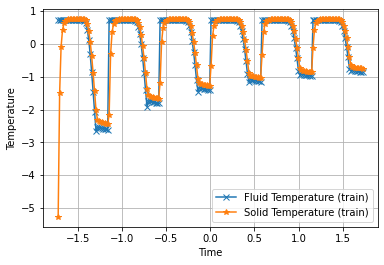

In [6]:
# Data loading Version 2

torch.manual_seed(42)
np.random.seed(42)

window_size = 34
window_step = 1

batch_size = 32

# load csv
train_df = pd.read_csv('data/TrainingData.txt', delimiter=',')

t_train_data = train_df['t'].values.reshape(-1, 1)
tf_train_data = train_df['tf0'].values.reshape(-1, 1)
ts_train_data = train_df['ts0'].values.reshape(-1, 1)

'''
# normalize data
begin_time = np.min(t_train_data)
end_time = np.max(t_train_data)
min_value_tf = np.min(tf_train_data)
max_value_tf = np.max(tf_train_data)
min_value_ts = np.min(ts_train_data)
max_value_ts = np.max(ts_train_data)

t_train_data -= begin_time
t_train_data = t_train_data / (end_time - begin_time)
tf_train_data -= min_value_tf
tf_train_data = tf_train_data / (max_value_tf - min_value_tf)
ts_train_data -= min_value_ts
ts_train_data = ts_train_data / (max_value_ts - min_value_ts)
'''

# Standardize data
mean_value_t = np.mean(t_train_data)
std_value_t = np.std(t_train_data)
mean_value_tf = np.mean(tf_train_data)
std_value_tf = np.std(tf_train_data)
mean_value_ts = np.mean(ts_train_data)
std_value_ts = np.std(ts_train_data)

t_train_data= (t_train_data - mean_value_t) / std_value_t
tf_train_data = (tf_train_data - mean_value_tf) / std_value_tf
ts_train_data = (ts_train_data - mean_value_ts) / std_value_ts


# plot training and test data
plt.plot(t_train_data, tf_train_data, label='Fluid Temperature (train)', marker='x')
plt.plot(t_train_data, ts_train_data, label='Solid Temperature (train)', marker='*')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.grid()
plt.legend()

# Create dataloaders    
t_training_data = torch.from_numpy(t_train_data).type(torch.float32)
tf_training_data = torch.from_numpy(tf_train_data).type(torch.float32)
ts_training_data = torch.from_numpy(ts_train_data).type(torch.float32)

training_set_tf = SlidingWindowDataset(time_data=t_training_data, temp_data=tf_training_data, window_size=window_size, step_size=window_step)
training_set_ts = SlidingWindowDataset(time_data=t_training_data, temp_data=ts_training_data, window_size=window_size, step_size=window_step)

training_loader_tf = torch.utils.data.DataLoader(training_set_tf, batch_size=batch_size, shuffle=True)
training_loader_ts = torch.utils.data.DataLoader(training_set_ts, batch_size=batch_size, shuffle=True)


In [7]:
modes = window_size // 2 + 1
width = 128

learning_rate = 0.001

n_epochs = 200
gamma = 0.5
step_size = 50
dropout_num = 0.2
dropout = True
BN = True

model_tf = FNO1d(modes, width, window_size, bn=BN, dropout=dropout, dropout_num=dropout_num)
model_ts = FNO1d(modes, width, window_size, bn=BN, dropout=dropout, dropout_num=dropout_num)

loss_tf = nn.MSELoss()
loss_ts = nn.MSELoss()

optimizer_tf = Adam(model_tf.parameters(), lr=learning_rate)
optimizer_ts = Adam(model_ts.parameters(), lr=learning_rate)

scheduler_tf = torch.optim.lr_scheduler.StepLR(optimizer_tf, step_size=step_size, gamma=gamma)
scheduler_ts = torch.optim.lr_scheduler.StepLR(optimizer_ts, step_size=step_size, gamma=gamma)

training_losses_tf = []
training_losses_ts = []

# train the models

for epoch in range(n_epochs):
    train_loss = 0.0
    for i, (inputs, labels) in enumerate(training_loader_tf):
        optimizer_tf.zero_grad()
        outputs = model_tf(inputs)
        loss = loss_tf(outputs, labels[:,:,1:])
        loss.backward()
        optimizer_tf.step()
        train_loss += loss.item()
    
    losses_tf = loss.item()
    training_losses_tf.append(losses_tf)
    print(f'Epoch {epoch}, loss {losses_tf}')
    #scheduler_tf.step()
print('Finished Training tf')

for epoch in range(n_epochs):
    train_loss = 0.0
    for i, (inputs, labels) in enumerate(training_loader_ts):
        optimizer_ts.zero_grad()
        outputs = model_ts(inputs)
        loss = loss_ts(outputs, labels[:,:,1:])
        loss.backward()
        optimizer_ts.step()
        train_loss += loss.item()

    losses_ts = loss.item()
    training_losses_ts.append(loss.item())
    print(f'Epoch {epoch}, loss {loss.item()}')
    #scheduler_ts.step()
print('Finished Training ts')

Epoch 0, loss 0.07645243406295776
Epoch 1, loss 0.02829076535999775
Epoch 2, loss 0.03481549024581909
Epoch 3, loss 0.03016788326203823
Epoch 4, loss 0.015379399061203003
Epoch 5, loss 0.014617731794714928
Epoch 6, loss 0.017544804140925407
Epoch 7, loss 0.011512456461787224
Epoch 8, loss 0.01107987854629755
Epoch 9, loss 0.012834764085710049
Epoch 10, loss 0.037516601383686066
Epoch 11, loss 0.012319325469434261
Epoch 12, loss 0.021476302295923233
Epoch 13, loss 0.010169394314289093
Epoch 14, loss 0.015072403475642204
Epoch 15, loss 0.012006181292235851
Epoch 16, loss 0.007881561294198036
Epoch 17, loss 0.010045469738543034
Epoch 18, loss 0.009166406467556953
Epoch 19, loss 0.006397944875061512
Epoch 20, loss 0.008884266950190067
Epoch 21, loss 0.01481375191360712
Epoch 22, loss 0.016165468841791153
Epoch 23, loss 0.012667846865952015
Epoch 24, loss 0.006237635854631662
Epoch 25, loss 0.00801172386854887
Epoch 26, loss 0.010354065336287022
Epoch 27, loss 0.010298851877450943
Epoch 28,

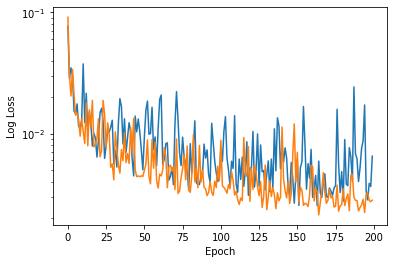

In [8]:
# Print loss
plt.plot(training_losses_tf)
plt.plot(training_losses_ts)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.savefig('loss_standardized.png')

In [9]:
# Evaluate the model

# Set the models to evaluation mode
model_tf.eval()
model_ts.eval()

# Get the last window_size data points from the training data

eval_data_t = torch.from_numpy(t_train_data[-window_size:]).type(torch.float32)
eval_data_tf = torch.from_numpy(tf_train_data[-window_size:]).type(torch.float32)
eval_data_ts = torch.from_numpy(ts_train_data[-window_size:]).type(torch.float32)

eval_set_tf = torch.cat((eval_data_t, eval_data_tf), dim=1)
eval_set_tf = eval_set_tf.unsqueeze(0)
eval_set_ts = torch.cat((eval_data_t, eval_data_ts), dim=1)
eval_set_ts = eval_set_ts.unsqueeze(0)

result_tf = model_tf(eval_set_tf)
result_ts = model_ts(eval_set_ts)

# Destandardize data

result_tf = result_tf.squeeze(2) * std_value_tf + mean_value_tf
result_ts = result_ts.squeeze(2) * std_value_ts + mean_value_ts

'''
# Denormalize data

result_tf = result_tf.squeeze(2) * (max_value_tf - min_value_tf) + min_value_tf
result_ts = result_ts.squeeze(2) * (max_value_ts - min_value_ts) + min_value_ts
'''

'\n# Denormalize data\n\nresult_tf = result_tf.squeeze(2) * (max_value_tf - min_value_tf) + min_value_tf\nresult_ts = result_ts.squeeze(2) * (max_value_ts - min_value_ts) + min_value_ts\n'

(210, 2)


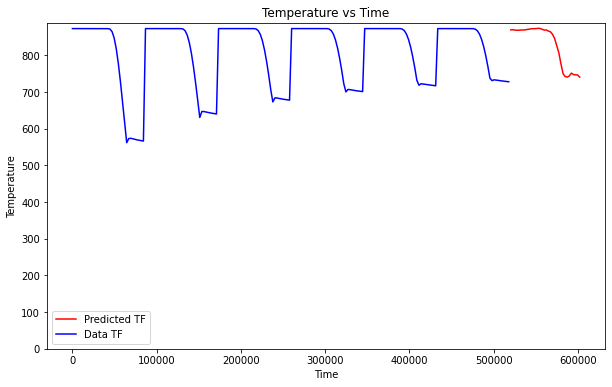

<Figure size 432x288 with 0 Axes>

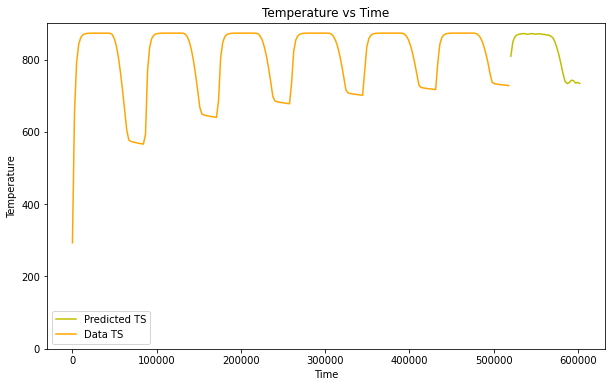

<Figure size 432x288 with 0 Axes>

In [10]:
# Plot the data and save the result to a CSV file

file_path = 'data/TrainingData.txt'
previous_data_tf = pd.read_csv(file_path, usecols=['t', 'tf0'])
previous_data_ts = pd.read_csv(file_path, usecols=['t', 'ts0'])

print(previous_data_tf.shape)

file_path = 'data/TestingData.txt'
pred_t = pd.read_csv(file_path, usecols=['t'])

result_tf_df = result_tf.detach().numpy()
result_tf_df = result_tf_df.reshape(34, 1)

result_ts_df = result_ts.detach().numpy()
result_ts_df = result_ts_df.reshape(34, 1)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(pred_t, result_tf_df, 'r', label='Predicted TF')
plt.plot(previous_data_tf['t'], previous_data_tf['tf0'], 'b', label='Data TF')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Temperature vs Time')
plt.legend()
plt.ylim(bottom=0)
plt.show()
plt.savefig('TF_standardized.png')


plt.figure(figsize=(10, 6))
plt.plot(pred_t, result_ts_df, 'y', label='Predicted TS')
plt.plot(previous_data_ts['t'], previous_data_ts['ts0'], 'orange', label='Data TS')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Temperature vs Time')
plt.legend()
plt.ylim(bottom=0)
plt.show()
plt.savefig('TS_standardized.png')

# Save the result to a CSV file
np.savetxt('result_tf.csv', result_tf_df, delimiter=',')